# Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
import nibabel.freesurfer.io as fsio
from nilearn import datasets, plotting
import random
from joblib import Parallel, delayed
from adjustText import adjust_text
from matplotlib.patches import Ellipse
import os

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# PLS Analysis Function

In [5]:
# inner parallelized
def regress_out_covariates(data, covariates, categorical_cols=None):
    """
    Regress out covariates from data using vectorized operations.
    Handles categorical variables by treating them as dummy variables.
    
    Parameters:
    data: DataFrame or array - the data to regress covariates from
    covariates: DataFrame - the covariate data
    categorical_cols: list - explicit list of column names to treat as categorical
    
    Returns:
    residuals: DataFrame or array - data with covariates regressed out
    """
    # Convert to numpy arrays for computation
    Y = np.array(data, dtype=float)
    
    # Handle categorical variables if DataFrame is passed
    if isinstance(covariates, pd.DataFrame):
        if categorical_cols is not None:
            # Explicitly specify which columns are categorical
            X_cov = pd.get_dummies(covariates, columns=categorical_cols, drop_first=True, dtype=float).values
        else:
            # Auto-detect categorical columns (object/string types)
            X_cov = pd.get_dummies(covariates, drop_first=True, dtype=float).values
    else:
        X_cov = np.array(covariates, dtype=float)
    
    # Add intercept column
    design_matrix = np.column_stack([np.ones(X_cov.shape[0]), X_cov])
    
    # Vectorized regression: solve for all columns simultaneously
    beta_coeffs = np.linalg.lstsq(design_matrix, Y, rcond=None)[0]
    
    # Calculate predictions and residuals
    predicted = design_matrix @ beta_coeffs
    residuals = Y - predicted
    
    # Return as DataFrame if input was DataFrame
    if isinstance(data, pd.DataFrame):
        return pd.DataFrame(residuals, index=data.index, columns=data.columns)
    else:
        return residuals


def pls_covariate_regression(X, y, brain_regions, X_covariates, y_covariates, 
                            categorical_cols=None, n_splits=10, weights_dir=None, 
                            data_name=None, target_name=None):
    """
    PLS regression analysis with demographic covariates regressed out beforehand.
    """
    # Separate demographic and brain region data
    X_demographic = X[X_covariates]
    y_demographic = X[y_covariates]
    X_brain = X[brain_regions]
    
    # Determine which covariates are categorical
    X_categorical = [col for col in X_covariates if col in (categorical_cols or [])]
    y_categorical = [col for col in y_covariates if col in (categorical_cols or [])]
    
    # Regress out demographic variables from brain regions
    print("Regressing out demographic variables from brain regions...")
    X_brain_residuals = regress_out_covariates(X_brain, X_demographic, X_categorical)
    
    # Regress out demographic variables from target variable
    print("Regressing out demographic variables from target variable...")
    y_residuals = regress_out_covariates(y, y_demographic, y_categorical)
    
    # Use only the residualized brain regions as features
    X_final = X_brain_residuals
    y_final = y_residuals.squeeze() if y_residuals.ndim > 1 else y_residuals
    
    # Simple preprocessing (just scaling, no categorical encoding needed)
    scaler = StandardScaler()
    
    # Cross-validation set-up
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    outer_mae, outer_rmse, outer_r2 = [], [], []
    best_ncomps = []
    coefs_list = []
    
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_final, y_final), start=1):
        X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
        
        # Handle y_final indexing based on its type
        if isinstance(y_final, pd.DataFrame) or isinstance(y_final, pd.Series):
            y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]
        else:
            # y_final is a numpy array
            y_train, y_test = y_final[train_idx], y_final[test_idx]
        
        # Scale features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Inner CV for PLS using GridSearchCV
        pls = PLSRegression()
        param_grid = {'n_components': list(range(1, 11))}  # n_components from 1 to 10
        
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        
        grid_search = GridSearchCV(
            pls, 
            param_grid, 
            cv=inner_cv, 
            scoring='neg_mean_squared_error', # or 'r2'
            n_jobs=-1
        )
        
        grid_search.fit(X_train_scaled, y_train)
        
        # Get best parameters
        best_n = grid_search.best_params_['n_components']
        best_ncomps.append(best_n)
        
        # Predict on test set
        y_pred = grid_search.predict(X_test_scaled)
        
        # --- metrics ---
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        outer_mae.append(mae)
        outer_rmse.append(rmse)
        outer_r2.append(r2)
        
        # Store coefficients
        coefs_list.append(grid_search.best_estimator_.coef_.ravel())
        
        print(f'Fold {fold:02d} • n_comp={best_n:02d} • '
              f'MAE={mae:.3f} • RMSE={rmse:.3f} • R²={r2:.3f}')
    
    # Aggregate results
    print('\n=== 10-fold CV summary ===')
    print(f'n_components (mean ± std): '
          f'{np.mean(best_ncomps):.1f} ± {np.std(best_ncomps):.1f}')
    print(f'MAE :  {np.mean(outer_mae):.3f} ± {np.std(outer_mae):.3f}')
    print(f'RMSE:  {np.mean(outer_rmse):.3f} ± {np.std(outer_rmse):.3f}')
    print(f'R²  :  {np.mean(outer_r2):.3f} ± {np.std(outer_r2):.3f}')
    
    # Final refit on all data if weights_dir is provided
    if weights_dir is not None and data_name is not None and target_name is not None:
        mean_ncomps = int(np.round(np.mean(best_ncomps)))
        
        # Scale all data
        X_final_scaled = scaler.fit_transform(X_final)
        
        # Train final PLS model
        final_pls = PLSRegression(n_components=mean_ncomps)
        final_pls.fit(X_final_scaled, y_final)
        
        # Get PLS weights
        W = final_pls.x_weights_
        
        # Create weights directory
        os.makedirs(weights_dir, exist_ok=True)
        
        # Create a DataFrame to store the weights
        weights_df = pd.DataFrame(W, 
                                  index=X_final.columns, 
                                  columns=[f'Component_{i+1}' for i in range(W.shape[1])])
        
        weights_filename = f'PLS_weights_{data_name}_{target_name}.csv'
        weights_filepath = os.path.join(weights_dir, weights_filename)
        weights_df.to_csv(weights_filepath)
        
        print(f"PLS weights saved to: {weights_filepath}")
        print(f"Final model parameters: n_components={mean_ncomps}")
    
    return {
        'mae': outer_mae,
        'rmse': outer_rmse,
        'r2': outer_r2,
        'best_ncomps': best_ncomps,
        'coefficients': coefs_list
    }

# GF

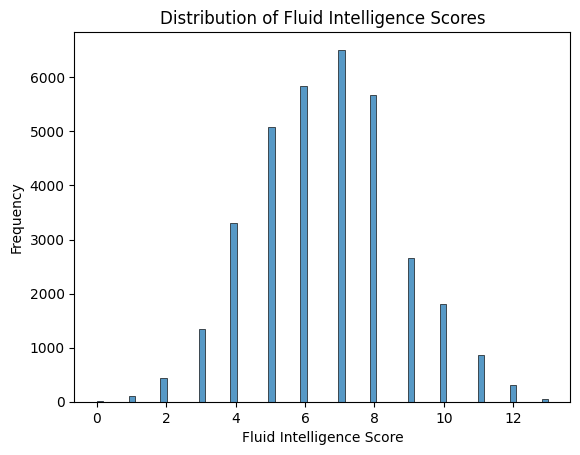

33977
(33977, 2628)


In [5]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_GF_no_outliers.csv', index_col=0)

# Histogram of Fluid Intelligence Scores
sns.histplot(df['20016-2.0'])
plt.title('Distribution of Fluid Intelligence Scores')
plt.xlabel('Fluid Intelligence Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

## GF vs. MIND (avg)

In [6]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 71), y: (33977,)


In [7]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=1.621 • RMSE=2.020 • R²=0.019
Fold 02 • n_comp=03 • MAE=1.634 • RMSE=2.032 • R²=0.017
Fold 03 • n_comp=03 • MAE=1.642 • RMSE=2.042 • R²=0.028
Fold 04 • n_comp=03 • MAE=1.654 • RMSE=2.059 • R²=0.017
Fold 05 • n_comp=03 • MAE=1.606 • RMSE=2.004 • R²=0.011
Fold 06 • n_comp=03 • MAE=1.583 • RMSE=1.976 • R²=0.022
Fold 07 • n_comp=03 • MAE=1.617 • RMSE=2.016 • R²=0.027
Fold 08 • n_comp=03 • MAE=1.657 • RMSE=2.052 • R²=0.010
Fold 09 • n_comp=03 • MAE=1.607 • RMSE=2.001 • R²=0.021
Fold 10 • n_comp=03 • MAE=1.628 • RMSE=2.033 • R²=0.020

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  1.625 ± 0.022
RMSE:  2.024 ± 0.024
R²  :  0.019 ± 0.006


## GF vs. MIND

In [6]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 2281), y: (33977,)


In [7]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10,
    weights_dir='/Users/baileyng/MIND_models/models_plsregression/PLS_weights',
    data_name='MIND',
    target_name='GF_pythonreg'
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=05 • MAE=1.603 • RMSE=2.002 • R²=0.036
Fold 02 • n_comp=05 • MAE=1.624 • RMSE=2.023 • R²=0.026
Fold 03 • n_comp=06 • MAE=1.631 • RMSE=2.037 • R²=0.033
Fold 04 • n_comp=05 • MAE=1.647 • RMSE=2.056 • R²=0.019
Fold 05 • n_comp=05 • MAE=1.597 • RMSE=1.994 • R²=0.020
Fold 06 • n_comp=05 • MAE=1.568 • RMSE=1.957 • R²=0.041
Fold 07 • n_comp=06 • MAE=1.605 • RMSE=2.005 • R²=0.037
Fold 08 • n_comp=04 • MAE=1.652 • RMSE=2.045 • R²=0.016
Fold 09 • n_comp=05 • MAE=1.604 • RMSE=1.996 • R²=0.026
Fold 10 • n_comp=05 • MAE=1.626 • RMSE=2.033 • R²=0.019

=== 10-fold CV summary ===
n_components (mean ± std): 5.1 ± 0.5
MAE :  1.616 ± 0.024
RMSE:  2.015 ± 0.028
R²  :  0.027 ± 0.008
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights/PLS_weights_MIND_GF_pythonreg.csv
Final model parameters: n_components=5


## GF vs. CT

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 65), y: (33977,)


In [11]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=07 • MAE=1.631 • RMSE=2.031 • R²=0.008
Fold 02 • n_comp=07 • MAE=1.643 • RMSE=2.040 • R²=0.009
Fold 03 • n_comp=07 • MAE=1.650 • RMSE=2.056 • R²=0.015
Fold 04 • n_comp=07 • MAE=1.662 • RMSE=2.071 • R²=0.005
Fold 05 • n_comp=07 • MAE=1.603 • RMSE=2.001 • R²=0.014
Fold 06 • n_comp=08 • MAE=1.591 • RMSE=1.986 • R²=0.011
Fold 07 • n_comp=07 • MAE=1.631 • RMSE=2.035 • R²=0.008
Fold 08 • n_comp=07 • MAE=1.652 • RMSE=2.046 • R²=0.016
Fold 09 • n_comp=07 • MAE=1.623 • RMSE=2.016 • R²=0.006
Fold 10 • n_comp=07 • MAE=1.638 • RMSE=2.044 • R²=0.009

=== 10-fold CV summary ===
n_components (mean ± std): 7.1 ± 0.3
MAE :  1.632 ± 0.021
RMSE:  2.033 ± 0.024
R²  :  0.010 ± 0.003


## GF vs. FC

In [12]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20016-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (33977, 214), y: (33977,)


In [13]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=05 • MAE=1.584 • RMSE=1.992 • R²=0.046
Fold 02 • n_comp=05 • MAE=1.609 • RMSE=2.000 • R²=0.049
Fold 03 • n_comp=04 • MAE=1.625 • RMSE=2.027 • R²=0.043
Fold 04 • n_comp=04 • MAE=1.620 • RMSE=2.022 • R²=0.052
Fold 05 • n_comp=05 • MAE=1.577 • RMSE=1.968 • R²=0.046
Fold 06 • n_comp=05 • MAE=1.552 • RMSE=1.935 • R²=0.062
Fold 07 • n_comp=05 • MAE=1.603 • RMSE=2.001 • R²=0.041
Fold 08 • n_comp=04 • MAE=1.609 • RMSE=2.007 • R²=0.053
Fold 09 • n_comp=05 • MAE=1.579 • RMSE=1.973 • R²=0.048
Fold 10 • n_comp=04 • MAE=1.602 • RMSE=2.002 • R²=0.050

=== 10-fold CV summary ===
n_components (mean ± std): 4.6 ± 0.5
MAE :  1.596 ± 0.021
RMSE:  1.992 ± 0.026
R²  :  0.049 ± 0.006


# PAL

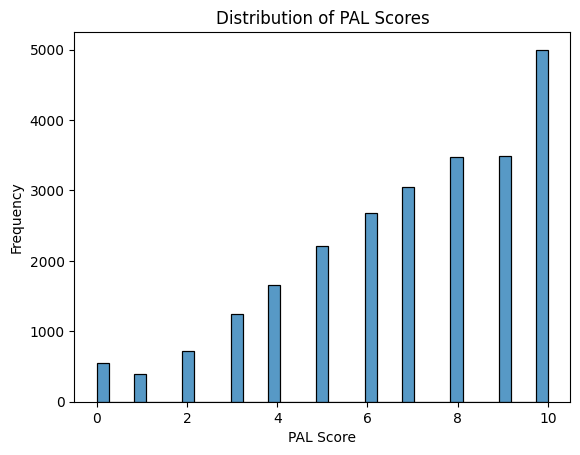

24492
(24492, 2628)


In [6]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_PAL_no_outliers.csv', index_col=0)

# Histogram of PAL Scores
sns.histplot(df['20197-2.0'])
plt.title('Distribution of PAL Scores')
plt.xlabel('PAL Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### PAL vs. MIND (avg)

In [6]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24492, 71), y: (24492,)


In [7]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=2.079 • RMSE=2.538 • R²=0.006
Fold 02 • n_comp=02 • MAE=2.106 • RMSE=2.552 • R²=0.001
Fold 03 • n_comp=02 • MAE=2.093 • RMSE=2.580 • R²=0.005
Fold 04 • n_comp=02 • MAE=2.068 • RMSE=2.531 • R²=0.004
Fold 05 • n_comp=02 • MAE=2.038 • RMSE=2.472 • R²=-0.003
Fold 06 • n_comp=02 • MAE=2.107 • RMSE=2.562 • R²=0.005
Fold 07 • n_comp=02 • MAE=2.091 • RMSE=2.541 • R²=0.002
Fold 08 • n_comp=02 • MAE=2.068 • RMSE=2.534 • R²=0.001
Fold 09 • n_comp=02 • MAE=2.080 • RMSE=2.550 • R²=0.006
Fold 10 • n_comp=02 • MAE=2.071 • RMSE=2.542 • R²=0.001

=== 10-fold CV summary ===
n_components (mean ± std): 2.0 ± 0.0
MAE :  2.080 ± 0.019
RMSE:  2.540 ± 0.027
R²  :  0.003 ± 0.003


### PAL vs. MIND

In [8]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24492, 2281), y: (24492,)


In [9]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10,
    weights_dir='/Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg',
    data_name='MIND',
    target_name='PAL'
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=2.067 • RMSE=2.533 • R²=0.010
Fold 02 • n_comp=02 • MAE=2.098 • RMSE=2.546 • R²=0.006
Fold 03 • n_comp=01 • MAE=2.088 • RMSE=2.573 • R²=0.010
Fold 04 • n_comp=02 • MAE=2.068 • RMSE=2.531 • R²=0.004
Fold 05 • n_comp=02 • MAE=2.034 • RMSE=2.467 • R²=0.001
Fold 06 • n_comp=02 • MAE=2.097 • RMSE=2.555 • R²=0.011
Fold 07 • n_comp=02 • MAE=2.082 • RMSE=2.530 • R²=0.010
Fold 08 • n_comp=02 • MAE=2.062 • RMSE=2.528 • R²=0.006
Fold 09 • n_comp=02 • MAE=2.086 • RMSE=2.560 • R²=-0.002
Fold 10 • n_comp=02 • MAE=2.072 • RMSE=2.542 • R²=0.000

=== 10-fold CV summary ===
n_components (mean ± std): 1.9 ± 0.3
MAE :  2.075 ± 0.018
RMSE:  2.537 ± 0.027
R²  :  0.006 ± 0.004
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg/PLS_weights_MIND_PAL.csv
Final model parameters: n_components=2


### PAL vs. CT

In [10]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24492, 65), y: (24492,)


In [11]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=2.079 • RMSE=2.535 • R²=0.008
Fold 02 • n_comp=03 • MAE=2.107 • RMSE=2.556 • R²=-0.002
Fold 03 • n_comp=03 • MAE=2.096 • RMSE=2.582 • R²=0.003
Fold 04 • n_comp=03 • MAE=2.065 • RMSE=2.532 • R²=0.004
Fold 05 • n_comp=03 • MAE=2.042 • RMSE=2.475 • R²=-0.005
Fold 06 • n_comp=03 • MAE=2.106 • RMSE=2.564 • R²=0.004
Fold 07 • n_comp=03 • MAE=2.086 • RMSE=2.537 • R²=0.005
Fold 08 • n_comp=03 • MAE=2.070 • RMSE=2.537 • R²=-0.002
Fold 09 • n_comp=03 • MAE=2.085 • RMSE=2.554 • R²=0.002
Fold 10 • n_comp=03 • MAE=2.073 • RMSE=2.539 • R²=0.002

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  2.081 ± 0.019
RMSE:  2.541 ± 0.027
R²  :  0.002 ± 0.004


### PAL vs. FC

In [12]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['20197-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24492, 214), y: (24492,)


In [13]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=2.044 • RMSE=2.511 • R²=0.027
Fold 02 • n_comp=03 • MAE=2.053 • RMSE=2.503 • R²=0.040
Fold 03 • n_comp=04 • MAE=2.071 • RMSE=2.558 • R²=0.022
Fold 04 • n_comp=04 • MAE=2.050 • RMSE=2.510 • R²=0.020
Fold 05 • n_comp=03 • MAE=1.996 • RMSE=2.419 • R²=0.040
Fold 06 • n_comp=03 • MAE=2.064 • RMSE=2.531 • R²=0.029
Fold 07 • n_comp=03 • MAE=2.049 • RMSE=2.503 • R²=0.032
Fold 08 • n_comp=03 • MAE=2.048 • RMSE=2.512 • R²=0.018
Fold 09 • n_comp=04 • MAE=2.045 • RMSE=2.520 • R²=0.029
Fold 10 • n_comp=03 • MAE=2.032 • RMSE=2.501 • R²=0.032

=== 10-fold CV summary ===
n_components (mean ± std): 3.3 ± 0.5
MAE :  2.045 ± 0.019
RMSE:  2.507 ± 0.033
R²  :  0.029 ± 0.007


# DSST

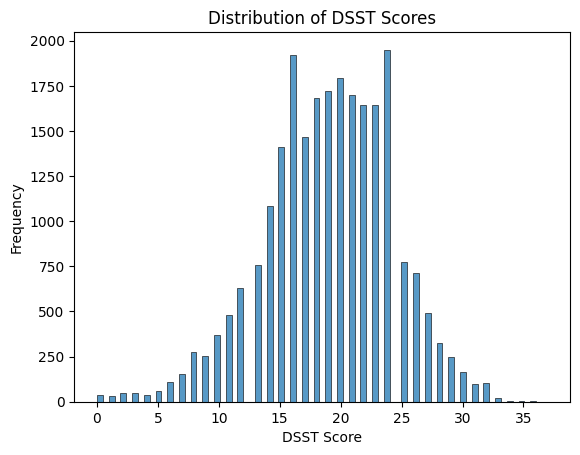

24275
(24275, 2628)


In [7]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_DSST_no_outliers.csv', index_col=0)

# Histogram of DSST Scores
sns.histplot(df['23324-2.0'])
plt.title('Distribution of DSST Scores')
plt.xlabel('DSST Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### DSST vs. MIND (avg)

In [15]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24275, 71), y: (24275,)


In [16]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=3.711 • RMSE=4.718 • R²=0.006
Fold 02 • n_comp=02 • MAE=3.797 • RMSE=4.840 • R²=0.004
Fold 03 • n_comp=02 • MAE=3.719 • RMSE=4.707 • R²=0.003
Fold 04 • n_comp=02 • MAE=3.660 • RMSE=4.612 • R²=0.008
Fold 05 • n_comp=02 • MAE=3.774 • RMSE=4.811 • R²=0.016
Fold 06 • n_comp=02 • MAE=3.702 • RMSE=4.741 • R²=0.003
Fold 07 • n_comp=02 • MAE=3.739 • RMSE=4.755 • R²=0.012
Fold 08 • n_comp=02 • MAE=3.715 • RMSE=4.740 • R²=0.014
Fold 09 • n_comp=02 • MAE=3.639 • RMSE=4.632 • R²=0.012
Fold 10 • n_comp=02 • MAE=3.640 • RMSE=4.594 • R²=0.012

=== 10-fold CV summary ===
n_components (mean ± std): 2.0 ± 0.0
MAE :  3.710 ± 0.050
RMSE:  4.715 ± 0.077
R²  :  0.009 ± 0.004


### DSST vs. MIND

In [8]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24275, 2281), y: (24275,)


In [9]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10,
    weights_dir='/Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg',
    data_name='MIND',
    target_name='DSST'
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=3.683 • RMSE=4.683 • R²=0.020
Fold 02 • n_comp=02 • MAE=3.785 • RMSE=4.813 • R²=0.015
Fold 03 • n_comp=02 • MAE=3.702 • RMSE=4.685 • R²=0.012
Fold 04 • n_comp=02 • MAE=3.657 • RMSE=4.605 • R²=0.011
Fold 05 • n_comp=02 • MAE=3.779 • RMSE=4.803 • R²=0.019
Fold 06 • n_comp=02 • MAE=3.693 • RMSE=4.725 • R²=0.010
Fold 07 • n_comp=02 • MAE=3.744 • RMSE=4.750 • R²=0.014
Fold 08 • n_comp=02 • MAE=3.704 • RMSE=4.731 • R²=0.018
Fold 09 • n_comp=02 • MAE=3.620 • RMSE=4.623 • R²=0.016
Fold 10 • n_comp=02 • MAE=3.646 • RMSE=4.584 • R²=0.016

=== 10-fold CV summary ===
n_components (mean ± std): 2.0 ± 0.0
MAE :  3.701 ± 0.052
RMSE:  4.700 ± 0.075
R²  :  0.015 ± 0.003
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg/PLS_weights_MIND_DSST.csv
Final model parameters: n_components=2


### DSST vs. CT

In [19]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24275, 65), y: (24275,)


In [20]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=3.710 • RMSE=4.714 • R²=0.007
Fold 02 • n_comp=04 • MAE=3.802 • RMSE=4.838 • R²=0.005
Fold 03 • n_comp=03 • MAE=3.718 • RMSE=4.718 • R²=-0.002
Fold 04 • n_comp=03 • MAE=3.657 • RMSE=4.608 • R²=0.010
Fold 05 • n_comp=04 • MAE=3.797 • RMSE=4.837 • R²=0.005
Fold 06 • n_comp=03 • MAE=3.701 • RMSE=4.732 • R²=0.007
Fold 07 • n_comp=04 • MAE=3.745 • RMSE=4.775 • R²=0.003
Fold 08 • n_comp=03 • MAE=3.724 • RMSE=4.752 • R²=0.009
Fold 09 • n_comp=03 • MAE=3.642 • RMSE=4.642 • R²=0.008
Fold 10 • n_comp=03 • MAE=3.648 • RMSE=4.610 • R²=0.005

=== 10-fold CV summary ===
n_components (mean ± std): 3.3 ± 0.5
MAE :  3.714 ± 0.053
RMSE:  4.723 ± 0.079
R²  :  0.006 ± 0.003


### DSST vs. FC

In [21]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['23324-2.0']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (24275, 214), y: (24275,)


In [22]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=3.683 • RMSE=4.690 • R²=0.017
Fold 02 • n_comp=03 • MAE=3.788 • RMSE=4.829 • R²=0.009
Fold 03 • n_comp=03 • MAE=3.723 • RMSE=4.700 • R²=0.006
Fold 04 • n_comp=03 • MAE=3.638 • RMSE=4.608 • R²=0.010
Fold 05 • n_comp=03 • MAE=3.788 • RMSE=4.822 • R²=0.011
Fold 06 • n_comp=03 • MAE=3.688 • RMSE=4.719 • R²=0.012
Fold 07 • n_comp=03 • MAE=3.725 • RMSE=4.745 • R²=0.016
Fold 08 • n_comp=02 • MAE=3.700 • RMSE=4.747 • R²=0.011
Fold 09 • n_comp=03 • MAE=3.636 • RMSE=4.622 • R²=0.016
Fold 10 • n_comp=03 • MAE=3.610 • RMSE=4.566 • R²=0.024

=== 10-fold CV summary ===
n_components (mean ± std): 2.9 ± 0.3
MAE :  3.698 ± 0.058
RMSE:  4.705 ± 0.083
R²  :  0.013 ± 0.005


# TMT

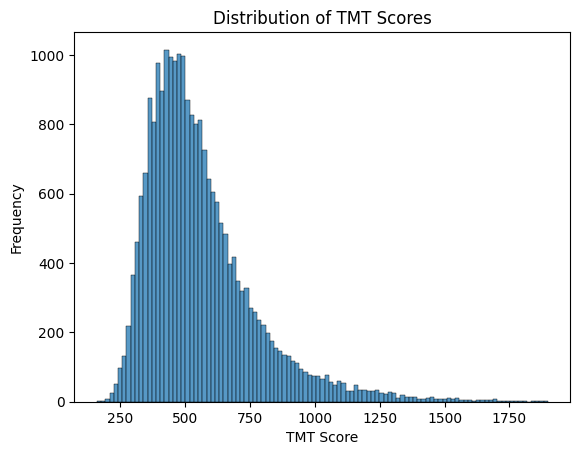

23362
(23362, 2628)


In [11]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_cog/ukb_master_TMT_no_outliers.csv', index_col=0)

# Histogram of TMT Scores
sns.histplot(df['trailmaking_score'])
plt.title('Distribution of TMT Scores')
plt.xlabel('TMT Score')
plt.ylabel('Frequency')
plt.show()

print(len(df))
print(df.shape)

### TMT vs. MIND (avg)

In [24]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23362, 71), y: (23362,)


In [25]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=152.073 • RMSE=204.460 • R²=-0.003
Fold 02 • n_comp=02 • MAE=142.844 • RMSE=190.931 • R²=0.003
Fold 03 • n_comp=02 • MAE=144.833 • RMSE=197.275 • R²=0.009
Fold 04 • n_comp=02 • MAE=142.673 • RMSE=197.198 • R²=0.010
Fold 05 • n_comp=02 • MAE=140.726 • RMSE=190.657 • R²=0.011
Fold 06 • n_comp=02 • MAE=144.212 • RMSE=200.979 • R²=0.014
Fold 07 • n_comp=02 • MAE=144.080 • RMSE=195.184 • R²=0.013
Fold 08 • n_comp=02 • MAE=146.350 • RMSE=203.773 • R²=0.012
Fold 09 • n_comp=02 • MAE=147.324 • RMSE=203.319 • R²=0.003
Fold 10 • n_comp=02 • MAE=147.096 • RMSE=202.215 • R²=0.020

=== 10-fold CV summary ===
n_components (mean ± std): 2.0 ± 0.0
MAE :  145.221 ± 3.016
RMSE:  198.599 ± 4.893
R²  :  0.009 ± 0.006


### TMT vs. MIND

In [13]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23362, 2281), y: (23362,)


In [14]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10,
    weights_dir='/Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg',
    data_name='MIND',
    target_name='TMT'
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=152.253 • RMSE=204.336 • R²=-0.001
Fold 02 • n_comp=02 • MAE=142.563 • RMSE=190.484 • R²=0.007
Fold 03 • n_comp=02 • MAE=144.577 • RMSE=196.835 • R²=0.013
Fold 04 • n_comp=03 • MAE=141.573 • RMSE=195.956 • R²=0.022
Fold 05 • n_comp=02 • MAE=140.252 • RMSE=189.945 • R²=0.018
Fold 06 • n_comp=02 • MAE=143.520 • RMSE=200.529 • R²=0.018
Fold 07 • n_comp=02 • MAE=143.546 • RMSE=194.620 • R²=0.019
Fold 08 • n_comp=02 • MAE=145.931 • RMSE=203.372 • R²=0.016
Fold 09 • n_comp=02 • MAE=147.260 • RMSE=203.224 • R²=0.004
Fold 10 • n_comp=02 • MAE=146.330 • RMSE=201.127 • R²=0.031

=== 10-fold CV summary ===
n_components (mean ± std): 2.2 ± 0.4
MAE :  144.780 ± 3.234
RMSE:  198.043 ± 5.008
R²  :  0.015 ± 0.009
PLS weights saved to: /Users/baileyng/MIND_models/models_plsregression/PLS_weights_reg/PLS_weights_MIND_TMT.csv
Final model parameters: n_component

### TMT vs. CT

In [28]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23362, 65), y: (23362,)


In [29]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=04 • MAE=152.199 • RMSE=204.327 • R²=-0.001
Fold 02 • n_comp=03 • MAE=142.802 • RMSE=190.923 • R²=0.003
Fold 03 • n_comp=03 • MAE=145.459 • RMSE=197.801 • R²=0.003
Fold 04 • n_comp=04 • MAE=141.739 • RMSE=197.460 • R²=0.007
Fold 05 • n_comp=03 • MAE=141.346 • RMSE=191.242 • R²=0.005
Fold 06 • n_comp=03 • MAE=145.006 • RMSE=201.427 • R²=0.009
Fold 07 • n_comp=03 • MAE=144.993 • RMSE=195.753 • R²=0.008
Fold 08 • n_comp=04 • MAE=147.480 • RMSE=204.838 • R²=0.002
Fold 09 • n_comp=04 • MAE=147.887 • RMSE=203.773 • R²=-0.001
Fold 10 • n_comp=03 • MAE=148.247 • RMSE=202.949 • R²=0.013

=== 10-fold CV summary ===
n_components (mean ± std): 3.4 ± 0.5
MAE :  145.716 ± 3.174
RMSE:  199.049 ± 4.965
R²  :  0.005 ± 0.004


### TMT vs. FC

In [30]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df['trailmaking_score']

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23362, 214), y: (23362,)


In [31]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=150.784 • RMSE=201.838 • R²=0.023
Fold 02 • n_comp=03 • MAE=142.130 • RMSE=190.022 • R²=0.012
Fold 03 • n_comp=03 • MAE=142.945 • RMSE=195.216 • R²=0.029
Fold 04 • n_comp=03 • MAE=139.500 • RMSE=193.562 • R²=0.046
Fold 05 • n_comp=03 • MAE=140.968 • RMSE=190.321 • R²=0.014
Fold 06 • n_comp=03 • MAE=143.474 • RMSE=198.562 • R²=0.037
Fold 07 • n_comp=03 • MAE=142.335 • RMSE=192.760 • R²=0.038
Fold 08 • n_comp=03 • MAE=144.704 • RMSE=200.359 • R²=0.045
Fold 09 • n_comp=03 • MAE=144.504 • RMSE=199.989 • R²=0.036
Fold 10 • n_comp=03 • MAE=146.438 • RMSE=201.198 • R²=0.030

=== 10-fold CV summary ===
n_components (mean ± std): 3.0 ± 0.0
MAE :  143.778 ± 2.989
RMSE:  196.383 ± 4.315
R²  :  0.031 ± 0.011


# All Cognitive Data

In [32]:
# Load the dataset
df = pd.read_csv('/Users/baileyng/MIND_data/ukb_master_allcols_no_outliers.csv', index_col=0)

print(len(df))
print(df.shape)

23188
(23188, 2628)


### All Data vs. MIND (avg)

In [33]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_avg_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23188, 72), y: (23188, 4)


In [34]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=02 • MAE=38.943 • RMSE=103.234 • R²=0.007
Fold 02 • n_comp=02 • MAE=38.933 • RMSE=99.933 • R²=0.009
Fold 03 • n_comp=02 • MAE=38.024 • RMSE=98.100 • R²=0.002
Fold 04 • n_comp=02 • MAE=37.313 • RMSE=97.088 • R²=0.007
Fold 05 • n_comp=02 • MAE=37.140 • RMSE=96.199 • R²=0.011
Fold 06 • n_comp=02 • MAE=37.361 • RMSE=98.198 • R²=0.009
Fold 07 • n_comp=02 • MAE=38.538 • RMSE=101.210 • R²=0.006
Fold 08 • n_comp=03 • MAE=37.222 • RMSE=96.391 • R²=0.008
Fold 09 • n_comp=02 • MAE=38.148 • RMSE=97.938 • R²=0.005
Fold 10 • n_comp=02 • MAE=37.113 • RMSE=97.393 • R²=0.005

=== 10-fold CV summary ===
n_components (mean ± std): 2.1 ± 0.3
MAE :  37.874 ± 0.701
RMSE:  98.568 ± 2.128
R²  :  0.007 ± 0.002


### All Data vs. MIND

In [35]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/MIND_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23188, 2282), y: (23188, 4)


In [36]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=03 • MAE=38.843 • RMSE=102.896 • R²=0.009
Fold 02 • n_comp=02 • MAE=38.811 • RMSE=99.770 • R²=0.012
Fold 03 • n_comp=03 • MAE=37.868 • RMSE=97.911 • R²=0.006
Fold 04 • n_comp=02 • MAE=37.238 • RMSE=96.877 • R²=0.010
Fold 05 • n_comp=03 • MAE=37.093 • RMSE=96.210 • R²=0.014
Fold 06 • n_comp=03 • MAE=37.381 • RMSE=98.223 • R²=0.010
Fold 07 • n_comp=02 • MAE=38.466 • RMSE=101.086 • R²=0.008
Fold 08 • n_comp=03 • MAE=37.097 • RMSE=96.036 • R²=0.012
Fold 09 • n_comp=03 • MAE=38.061 • RMSE=97.941 • R²=0.007
Fold 10 • n_comp=02 • MAE=37.096 • RMSE=97.253 • R²=0.008

=== 10-fold CV summary ===
n_components (mean ± std): 2.6 ± 0.5
MAE :  37.795 ± 0.679
RMSE:  98.420 ± 2.093
R²  :  0.010 ± 0.002


### All Data vs. CT

In [37]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/CT_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23188, 66), y: (23188, 4)


In [38]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=08 • MAE=39.043 • RMSE=103.296 • R²=0.004
Fold 02 • n_comp=09 • MAE=39.166 • RMSE=100.361 • R²=0.001
Fold 03 • n_comp=09 • MAE=37.869 • RMSE=98.123 • R²=0.003
Fold 04 • n_comp=09 • MAE=37.554 • RMSE=97.283 • R²=0.004
Fold 05 • n_comp=09 • MAE=37.289 • RMSE=96.910 • R²=0.004
Fold 06 • n_comp=04 • MAE=37.538 • RMSE=98.663 • R²=0.004
Fold 07 • n_comp=09 • MAE=38.776 • RMSE=101.466 • R²=0.003
Fold 08 • n_comp=09 • MAE=37.371 • RMSE=96.384 • R²=0.004
Fold 09 • n_comp=04 • MAE=38.264 • RMSE=98.215 • R²=0.001
Fold 10 • n_comp=09 • MAE=37.056 • RMSE=97.301 • R²=0.004

=== 10-fold CV summary ===
n_components (mean ± std): 7.9 ± 2.0
MAE :  37.993 ± 0.731
RMSE:  98.800 ± 2.110
R²  :  0.003 ± 0.001


### All Data vs. FC

In [39]:
# Set X and y
with open('/Users/baileyng/MIND_models/region_names/FC_regions.txt', 'r') as f:
    brain_regions = [line.strip() for line in f.readlines()]

# Define different covariates for X and y
X_covariates = ['31-0.0', '21003-2.0', '54-2.0', '25741-2.0']  
y_covariates = ['31-0.0', '21003-2.0', '54-2.0']  

# Combine all variables
all_vars = list(set(X_covariates + y_covariates + brain_regions))

X = df[all_vars]
y = df[['20016-2.0', '20197-2.0', '23324-2.0', 'trailmaking_score']]

print(f"Original shapes - X: {X.shape}, y: {y.shape}")

# rename columns
X = X.rename(columns=rename_dict)

# Update variable names after renaming
X_covariates_renamed = [rename_dict.get(var, var) for var in X_covariates]
y_covariates_renamed = [rename_dict.get(var, var) for var in y_covariates]
brain_regions_renamed = [rename_dict.get(var, var) for var in brain_regions]

# Specify which variables are categorical
categorical_variables = ['sex', 'assessment_centre']  # Use renamed column names

Original shapes - X: (23188, 214), y: (23188, 4)


In [40]:
# Run PLS analysis with covariate regression
results = pls_covariate_regression(
    X, y, brain_regions_renamed, X_covariates_renamed, y_covariates_renamed, 
    categorical_cols=categorical_variables, n_splits=10
)

Regressing out demographic variables from brain regions...
Regressing out demographic variables from target variable...
Fold 01 • n_comp=07 • MAE=38.648 • RMSE=102.478 • R²=0.027
Fold 02 • n_comp=05 • MAE=37.917 • RMSE=97.429 • R²=0.040
Fold 03 • n_comp=07 • MAE=37.531 • RMSE=97.283 • R²=0.023
Fold 04 • n_comp=05 • MAE=36.857 • RMSE=95.742 • R²=0.032
Fold 05 • n_comp=05 • MAE=36.875 • RMSE=95.423 • R²=0.029
Fold 06 • n_comp=05 • MAE=36.876 • RMSE=96.827 • R²=0.032
Fold 07 • n_comp=07 • MAE=38.747 • RMSE=100.782 • R²=0.024
Fold 08 • n_comp=05 • MAE=36.769 • RMSE=95.500 • R²=0.028
Fold 09 • n_comp=07 • MAE=37.542 • RMSE=96.666 • R²=0.025
Fold 10 • n_comp=06 • MAE=36.683 • RMSE=95.824 • R²=0.027

=== 10-fold CV summary ===
n_components (mean ± std): 5.9 ± 0.9
MAE :  37.444 ± 0.736
RMSE:  97.395 ± 2.255
R²  :  0.029 ± 0.005
